In [ ]:
!pip install pennylane

### **Implemention of a Quantum Machine Learning model which reproduces the values of the sine function.**

**Task:**  Develop a model and use it to learn the sine function on the interval [0, 2π]. Discretize the interval with a suitable number of points (of your choice) and use the values of the sine function at these discretization points as labels.


In [ ]:
#Imports
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

#### Next, Initialize a quantum device with a single qubit.

The choice of one qubit is sufficient for this task since we only have one feature (x).

In [ ]:
# Set up the quantum device
num_wires=1
dev = qml.device("default.qubit", wires=num_wires)

Let's construct the variational classifier where the parameters will be optimized during training to minimize the error in predicting the sine function.

In this model, the number of gates is determined by the number of parameters, enabling a deeper circuit.

In [ ]:
#Defining the variational circuit
def quantum_circuit(params, x):

  #Encoding the data using angle embeding technique
    qml.RX(x, wires=0)

#parameterized circuit
    for k in range(len(params) // 3):
        qml.RY(params[3 * k], wires=0)
        qml.RZ(params[3 * k + 1], wires=0)
        qml.RY(params[3 * k + 2], wires=0)
    return qml.expval(qml.PauliZ(0))

#create a qnode for the execution of the quantum circuit
qnode = qml.QNode(quantum_circuit, dev)

Now, we define a function that quantifies how well the model is performing, guiding the optimization process.This computes the mean squared error (MSE) between predictions and targets.

In [ ]:
# Define the lost function
def loss_fun(predictions, targets):
    diff = predictions - targets
    squared_diff = diff ** 2
    mse = pnp.mean(squared_diff)
    return mse

The cost function to evaluate how well the model performs with the current parameters.

In [ ]:
# Define the cost function
def cost_fun(params, X, Y):
    predictions = pnp.array([qnode(params, x) for x in X])
    cost = loss_fun(predictions, Y)
    return cost

Let's generate the training data points for the sine function.

In [ ]:
# Generate training data
num_points = 20
X = pnp.linspace(0, 2 * pnp.pi, num_points)
Y = pnp.sin(X)

# Generate test data slightly offset from training data
X_test = pnp.linspace(0.2, 2 * pnp.pi + 0.2, num_points)
Y_test = pnp.sin(X_test)

Function to calculate the accuracy based on the predictions and the true values.

In [ ]:
def accuracy(predictions, targets, threshold=0.1):
    correct_predictions = pnp.abs(predictions - targets) < threshold
    return pnp.mean(correct_predictions)

training the model and optimizing the parameters

In [ ]:
# Initialize parameters using PennyLane numpy
params = pnp.array([0.1] * 3, requires_grad=True)

print(f"Initial parameters: {params}\n")

# Train the model
learning_rate=0.1
opt = AdamOptimizer(stepsize=learning_rate)
num_steps = 100

# Initialize lists to store cost and accuracy values
cost_values = []
accuracy_values = []

for step in range(num_steps):
    params, prev_cost = opt.step_and_cost(lambda v: cost_fun(v, X, Y), params)
    cost_values.append(prev_cost)

    # Calculate accuracy
    predictions = pnp.array([qnode(params, x) for x in X])
    acc = accuracy(predictions, Y)
    accuracy_values.append(acc)

    if step % 10 == 0:
        cost = cost_fun(params, X, Y)
        print(f"Step {step:3d}: cost = {cost:.10f}, accuracy = {acc:.4f}")
print()
print(f"Final parameters: {params}\n")
print()

Initial parameters: [0.1 0.1 0.1]

Step   0: cost = 0.9203855839, accuracy = 0.0000
Step  10: cost = 0.0536009924, accuracy = 0.2000
Step  20: cost = 0.0214389296, accuracy = 0.3500
Step  30: cost = 0.0003971748, accuracy = 1.0000
Step  40: cost = 0.0018496602, accuracy = 1.0000
Step  50: cost = 0.0017997633, accuracy = 1.0000
Step  60: cost = 0.0008983062, accuracy = 1.0000
Step  70: cost = 0.0003654850, accuracy = 1.0000
Step  80: cost = 0.0001535688, accuracy = 1.0000
Step  90: cost = 0.0000730328, accuracy = 1.0000

Final parameters: [ 1.39475775 -1.58947862  1.69788846]




Evaluating the model on unseen data.

In [ ]:
# Evaluate the model
test_predictions = pnp.array([qnode(params, x) for x in X_test])

 Let's assess how well the model approximates the sine function across the input range by visualizing the training labels, test labels, and model predictions.

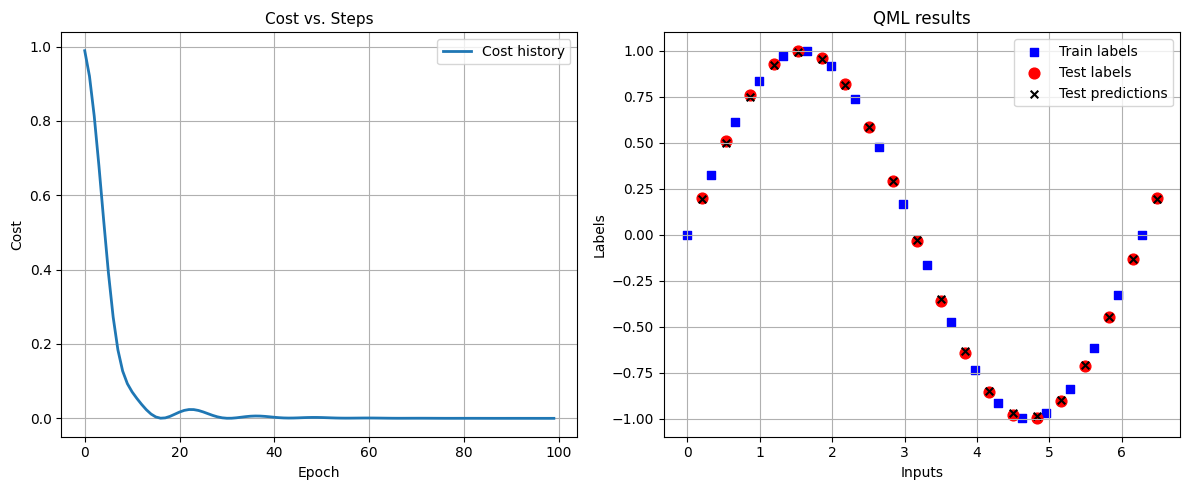

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cost_values, lw=2, label='Cost history')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost vs. Steps', fontsize=11)
plt.legend(loc='upper right')
plt.grid(True)

ax2 = plt.subplot(1, 2, 2)
plt.scatter(X, Y, s=30, c='b', marker='s', label='Train labels')
plt.scatter(X_test, Y_test, s=60, c='r', marker='o', label='Test labels')
plt.scatter(X_test, test_predictions, s=30, c='k', marker='x', label='Test predictions')
plt.title('Model Predictions vs. True Function', fontsize=11)
plt.xlabel('Inputs')
plt.ylabel('Labels')
plt.title('QML results')
plt.legend(loc='upper right')
plt.grid(True)

# Adjust layout to minimize overlap and make use of available space
plt.tight_layout()

# Save the entire figure
plt.savefig('sine_function.png', dpi=300, bbox_inches='tight')

**The Cost vs. Steps** plot shows how the cost function (likely the loss function) changes over the course of training epochs. We can observe that the cost starts high, around 1, and decreases sharply during the early epochs, indicating that the model is learning quickly. We notice slight oscillations around the minimum cost between epoch 19 to 40, showing that the model undergoes some fine-tuning as it converges to an optimal solution.
The cost eventually stabilizes close to zero, which suggests that the model has minimized the error in predicting the sine function values.

**The QML result graph** compares the true labels (training and test data) against the model's predictions. The test predictions seem to closely follow the sine wave, indicating that the model has successfully learned to approximate the sine function for the given input range.


Plot the accuracy values over the training steps.

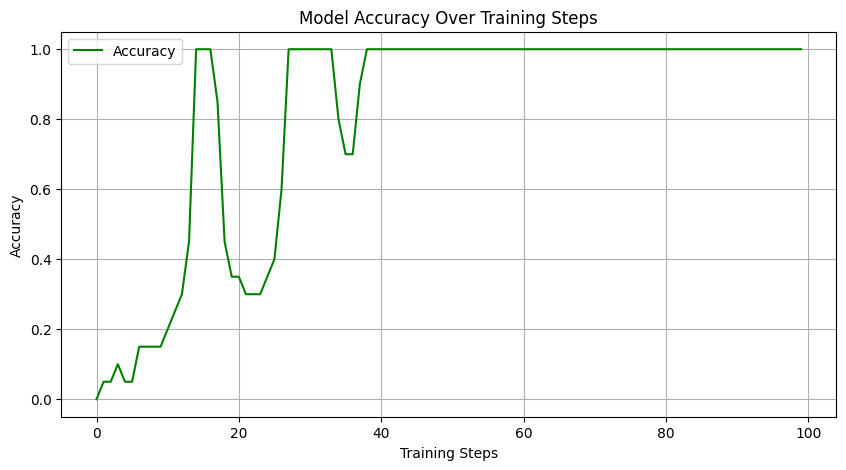

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values, label='Accuracy', color='green')
plt.title('Model Accuracy Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


From **the model accuracy over training steps graph**, we see that, the accuracy starts very low and increases steadily with training, eventually reaching 100%.
The fluctuations in accuracy indicate that the model experienced some challenges in correctly predicting all points initially, but eventually, it achieved perfect accuracy.
The plateau at 1.0 accuracy suggests that the model has generalized well to the sine function over the input interval.

In conclusion, we can say that our QML model have learned the sine function effectively, as indicated by the reduction in cost, the accuracy improvements over time, and the closeness of the predictions to the actual sine values in the second plot

Reference:

https://www.youtube.com/watch?v=2i9cwlonRL0&list=PL_wGNAk5B0pXq98BJBKsbNH2Qjp1lk8dG&index=24&ab_channel=WOMANIUM